In [1]:
# from sklearn.preprocessing import PolynomialFeatures
import numpy as np
# import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
# import randcbpside
# import randcbpside2
import games 
# import random
import math
# import pandas as pd
import synthetic_data


class Evaluation_contextual:

    def __init__(self, horizon ):

        self.horizon = horizon

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):#jobid
        context_generator, seed = job
        np.random.seed(seed)
        
    
        cumRegret =  np.zeros(self.horizon, dtype =float)
        actions = np.zeros(self.horizon, dtype =float)


        for t in range(self.horizon):
            print(t)
            context, distribution = context_generator.get_context(True)
            print(distribution)
            # distribution = context_generator.get_distribution(context)
            # outcome = np.random.choice( 2 , p = distribution )
            outcome = 0 if distribution[0]<0.5 else 1
            distribution = np.array([1-outcome,outcome])

            action = alg.get_action(t, context)
            
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )
            

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            
            print(action, outcome, val)
            # print(i_star)
            # print()

            # regret = game.LossMatrix[action, outcome] - np.min( game.LossMatrix[...,outcome] )

            cumRegret[t] =  val
            actions[t] = action

        return  np.cumsum( cumRegret ) 

In [5]:
horizon = 5000
# nfolds = 10
game = games.apple_tasting(False)
import randcbpside2
import PGTS
import PGIDSratio
import random_algo
import cbpside

class LinearContexts:
    def __init__(self, w):
        self.d = len(w) #number of features
        self.w = w
        self.type = 'linear'
        self.normalize()

    def normalize(self,):
        all = []
        for _ in range(100000):
            c,d = self.get_context(False)
            all.append( c )
        all = np.array(all)
        self.mean = np.mean(all,0)
        self.std = np.std(all,0 )

    def get_context(self, normalize):
        context = np.random.uniform(0, 1,  self.d )
        context = np.array(context).reshape(self.d,1)
        val = self.w @ context
        distribution = [ val[0], 1-val[0] ]
        if normalize:
            context = ( context - self.mean ) / self.std
        return context, distribution

dim = 10
w = np.random.uniform(0, 0.1, 10)
w = w / w.sum()
context_generator = LinearContexts( w ) 


# import STAP_Helmbolt
# alg = STAP_Helmbolt.STAP_Helmbolt(game, dim,)
# alg.reset(dim)

alg = random_algo.Random(game,horizon)
# alg = PGTS.PGTS(game, dim,)
# alg = PGIDSratio.PGIDSratio(game, dim,)
# alg = randcbpside2.RandCPBside(game, dim, 1.01, 0.05, 1000, 10, 10e-7)
# alg = cbpside.CBPside(game, dim, 1.01, 0.05)
# alg.reset()

eval = Evaluation_contextual(horizon)

res = eval.eval_policy_once(alg, game, [ context_generator , 0  ] )

0
[0.6010973925011684, 0.39890260749883155]
1 1 1
1
[0.5685710134108829, 0.4314289865891171]
1 1 1
2
[0.39604542686688043, 0.6039545731331195]
0 0 1
3
[0.5904466489880358, 0.4095533510119642]
0 1 0
4
[0.40684503290863994, 0.5931549670913601]
0 0 1
5
[0.2869549259832194, 0.7130450740167806]
0 0 1
6
[0.6907862776495967, 0.30921372235040334]
0 1 0
7
[0.3565891032503016, 0.6434108967496984]
0 0 1
8
[0.3805995078019103, 0.6194004921980897]
1 0 0
9
[0.5385659625272106, 0.46143403747278944]
1 1 1
10
[0.6625162428273517, 0.33748375717264834]
1 1 1
11
[0.483960941035785, 0.516039058964215]
0 0 1
12
[0.5702434801428263, 0.42975651985717367]
0 1 0
13
[0.6497773544821575, 0.35022264551784255]
1 1 1
14
[0.5709128868976103, 0.4290871131023897]
1 1 1
15
[0.33173105917626, 0.66826894082374]
0 0 1
16
[0.45082940858286835, 0.5491705914171316]
1 0 0
17
[0.4878420151161909, 0.5121579848838091]
0 0 1
18
[0.31882705229738817, 0.6811729477026118]
1 0 0
19
[0.4507149113630288, 0.5492850886369711]
1 0 0
20
[0.

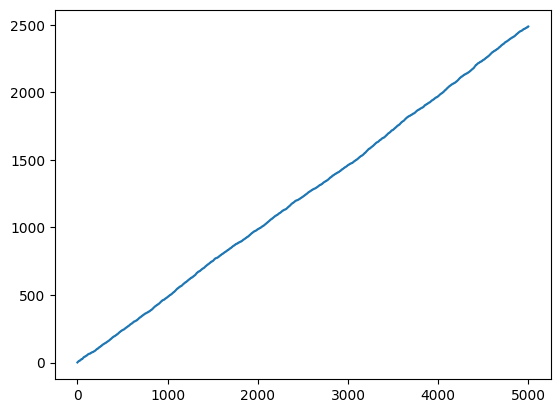

In [6]:
import matplotlib.pyplot as plt
plt.plot( range(horizon), res, label = 'helmbolt' )

In [22]:


dim = 10
w = np.random.uniform(0, 0.1, 10)
w = w / w.sum()
context_generator = LinearContexts( w ) 

all = []
for _ in range(100000):
    c = context_generator.get_context(True)
    all.append( c )

all = np.array(all)


res3

In [2]:
import numpy as np

class Evaluation:

    def __init__(self, horizon,task):
        self.task = task
        self.horizon = horizon

    def get_outcomes(self, game):
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()
        distribution, jobid, label, nfolds = job
        np.random.seed(jobid)

        outcome_distribution =  {'spam':distribution[0], 'ham':distribution[1]}

        game.set_outcome_distribution( outcome_distribution , jobid )

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game )

        for t in range(self.horizon):
            #print(t)

            # Environment chooses one outcome and one context associated to this outcome
            outcome = outcomes[t]

            # policy chooses one action
            # print('t', t,  'outcome', outcome, 'context', context)
            action = alg.get_action(t)

            print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, None )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]
            
            result = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter

        return  result 


eval = Evaluation(500, 'imbalanced', )
import randcbp
import games
game = games.apple_tasting(False)
alg = randcbp.RandCBP(game,1.01,1/8,10,10e-7)
job = [0.15,1-0.15], 0, None, None
eval.eval_policy_once(alg,game,job)

t 0 action 0 outcome 1
t 1 action 1 outcome 1
rhos [0.0, 0.09296744766583921, 0.18593489533167842, 0.27890234299751765, 0.37186979066335685, 0.46483723832919605, 0.5578046859950353, 0.6507721336608745, 0.7437395813267137, 0.8367070289925529]
0.18593489533167842
t 2 action 0 outcome 1
rhos [0.0, 0.11704164140024731, 0.23408328280049462, 0.35112492420074193, 0.46816656560098924, 0.5852082070012365, 0.7022498484014839, 0.8192914898017312, 0.9363331312019785, 1.0533747726022258]
0.23408328280049462
t 3 action 0 outcome 1
rhos [0.0, 0.13147582534824076, 0.2629516506964815, 0.3944274760447223, 0.525903301392963, 0.6573791267412038, 0.7888549520894446, 0.9203307774376853, 1.051806602785926, 1.1832824281341667]
0.525903301392963
t 4 action 0 outcome 1
rhos [0.0, 0.1416626270255611, 0.2833252540511222, 0.4249878810766833, 0.5666505081022444, 0.7083131351278055, 0.8499757621533666, 0.9916383891789277, 1.1333010162044888, 1.2749636432300497]
0.8499757621533666
t 5 action 0 outcome 1
rhos [0.0, 0.

array([0. , 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
       1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
       1.4, 1.4, 1.4, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5,
       3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.